Saving Womens Clothing E-Commerce Reviews (1).csv to Womens Clothing E-Commerce Reviews (1) (1).csv
Файл: Womens Clothing E-Commerce Reviews (1) (1).csv
Найдены колонки: Columns(text='Review Text', title='Title', rating='Rating', posfb='Positive Feedback Count')


/tmp/ipython-input-298506486.py:130: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  has_link     = s_.str.contains(link_re)
/tmp/ipython-input-298506486.py:131: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  has_phone    = s_.str.contains(phone_re)


Всего строк: 23486 | найдено позитивов по эвристикам: 149 (0.63%)
Сэмпл сформирован: 3000 строк (позитивов в сэмпле: 149)
Размерность X: (3000, 20082)

=== Logistic Regression ===
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       570
           1      1.000     1.000     1.000        30

    accuracy                          1.000       600
   macro avg      1.000     1.000     1.000       600
weighted avg      1.000     1.000     1.000       600

Confusion matrix:
 [[570   0]
 [  0  30]]

=== Random Forest ===
ROC-AUC: 0.992
              precision    recall  f1-score   support

           0      0.952     1.000     0.975       570
           1      1.000     0.033     0.065        30

    accuracy                          0.952       600
   macro avg      0.976     0.517     0.520       600
weighted avg      0.954     0.952     0.930       600

Confusion matrix:
 [[570   0]
 [ 29   1]]


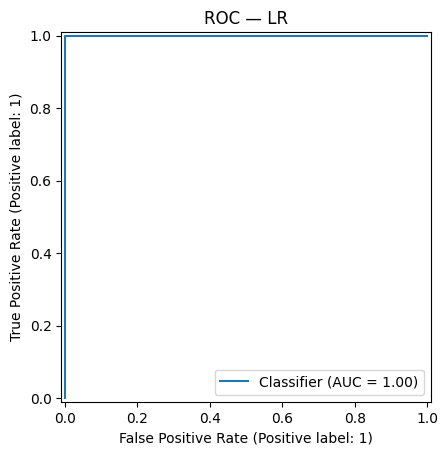

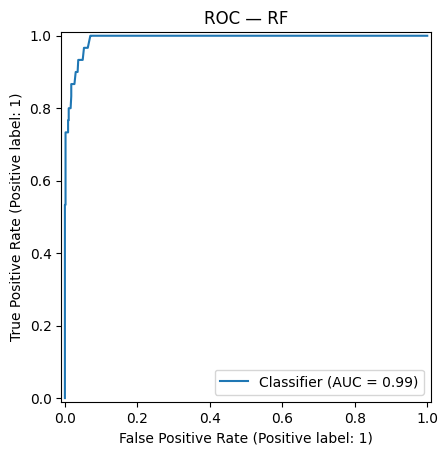

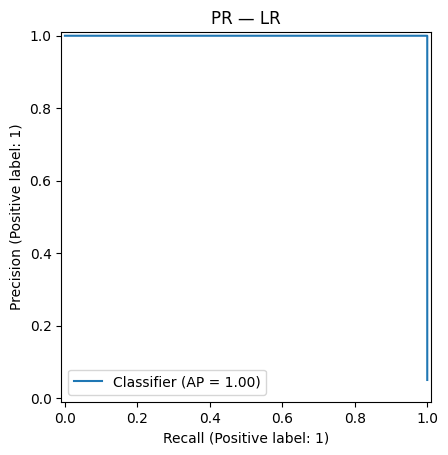

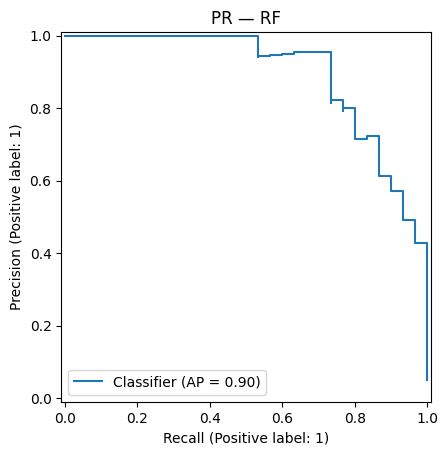


>>> Лучшая модель по AUC: LR

Сохранено: reviews_scored.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Сохранены модели: model_lr.joblib, model_rf.joblib, vectorizer_meta.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Примеры predict_one():
Write me on telegram t.me/superdeal for a 70% discount!!! -> {'model': 'LR', 'score': 0.996, 'label': 1, 'flags': ['contact', 'many_exclam']}
Contact via WhatsApp +1 (202) 555-0123 for refund outside the platform -> {'model': 'LR', 'score': 1.0, 'label': 1, 'flags': ['phone', 'contact']}
Let's move on to Facebook @alex328, write me for discount please -> {'model': 'LR', 'score': 0.009, 'label': 0, 'flags': []}
100% not fake, dm me for discount -> {'model': 'LR', 'score': 0.978, 'label': 1, 'flags': ['contact']}
free shop -> {'model': 'LR', 'score': 0.008, 'label': 0, 'flags': []}
+6 (211) 310-12 contact me through number or axelshop.com! -> {'model': 'LR', 'score': 1.0, 'label': 1, 'flags': ['phone', 'contact']}


/tmp/ipython-input-298506486.py:272: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  "has_link":    s_.str.contains(link_re).astype(int),
/tmp/ipython-input-298506486.py:273: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  "has_phone":   s_.str.contains(phone_re).astype(int),
/tmp/ipython-input-298506486.py:272: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  "has_link":    s_.str.contains(link_re).astype(int),
/tmp/ipython-input-298506486.py:273: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  "has_phone":   s_.str.contains(phone_re).astype(int),
/tmp/ipython-input-298506486.py:272: UserWarning: This pattern is interpreted as a regular express

In [ ]:
# ============================================================
# Colab: weak-fraud detector (Excel/CSV) — SAMPLE_N = 3000
# - загружаем файл через диалог
# - считаем флаги по всему датасету
# - формируем сэмпл 3000: все позитивы + случайные негативы
# - 2 модели: LR и RF, метрики/графики, сохранение артефактов
# ============================================================

!pip -q install pandas scikit-learn numpy joblib openpyxl

import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from google.colab import files
from dataclasses import dataclass
from typing import Optional, List
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             RocCurveDisplay, PrecisionRecallDisplay)
from joblib import dump

# ---------- настройки ----------
SAMPLE_N = 3000      # <- просили 3k
RANDOM_STATE = 42

# ---------- загрузка файла ----------
uploaded = files.upload()
if not uploaded:
    raise SystemExit("Файл не загружен.")
PATH = list(uploaded.keys())[0]
print("Файл:", PATH)

# ---------- чтение файла ----------
ext = os.path.splitext(PATH)[1].lower()
if ext in (".xlsx", ".xls"):
    df_raw = pd.read_excel(PATH)
elif ext == ".csv":
    df_raw = pd.read_csv(PATH, engine="python")
else:
    raise ValueError(f"Неподдерживаемый формат: {ext}. Используй .xlsx/.xls/.csv")

# ---------- кандидаты колонок ----------
TEXT_COLS = ["Review Text","review_text","review","Text","Body","Отзыв","Текст","Комментарий"]
TITLE_COLS = ["Title","Review Title","title","Заголовок"]
RATING_COLS = ["Rating","rating","Stars","stars","Оценка"]
POSFB_COLS = ["Positive Feedback Count","positive_feedback_count","helpfulness","helpful","Полезность","Лайки"]

def pick_col(df: pd.DataFrame, cands: List[str]) -> Optional[str]:
    low = {c.lower(): c for c in df.columns}
    for c in cands:
        if c in df.columns: return c
        if c.lower() in low: return low[c.lower()]
    for c in df.columns:
        cl = c.lower()
        for cand in cands:
            if cand.lower() in cl:
                return c
    return None

@dataclass
class Columns:
    text: str
    title: Optional[str]
    rating: Optional[str]
    posfb: Optional[str]

def detect_columns(df: pd.DataFrame) -> Columns:
    t = pick_col(df, TEXT_COLS)
    if not t:
        raise RuntimeError(f"Не нашёл колонку с текстом. Нашлись: {list(df.columns)}")
    return Columns(
        text=t,
        title=pick_col(df, TITLE_COLS),
        rating=pick_col(df, RATING_COLS),
        posfb=pick_col(df, POSFB_COLS)
    )

cols = detect_columns(df_raw)
print("Найдены колонки:", cols)

# ---------- сбор полного текста (для ВСЕГО набора) ----------
text_full = df_raw[cols.text].astype(str).fillna("")
if cols.title:
    text_full = (df_raw[cols.title].astype(str).fillna("") + ". " + text_full).str.strip()

# доп. числовые (если есть)
extras_list = []
if cols.rating and df_raw[cols.rating].notna().any():
    rating_full = df_raw[cols.rating].astype(float).fillna(df_raw[cols.rating].median()).values.reshape(-1,1)
    extras_list.append(rating_full)
else:
    rating_full = None

if cols.posfb and df_raw[cols.posfb].notna().any():
    posfb_full = np.log1p(df_raw[cols.posfb].astype(float).fillna(0)).values.reshape(-1,1)
    extras_list.append(posfb_full)
else:
    posfb_full = None

extra_mat_full = None
if extras_list:
    extra_mat_full = np.hstack(extras_list)
    scaler = StandardScaler(with_mean=True)
    extra_mat_full = scaler.fit_transform(extra_mat_full)
    extra_mat_full = csr_matrix(extra_mat_full)
num_extra = extra_mat_full.shape[1] if extra_mat_full is not None else 0

# ---------- эвристики по ВСЕМ строкам ----------
CONTACT_WORDS = [
    "telegram","t.me","tg ","whatsapp","wa.me","wechat","viber","signal",
    "email","mail me","contact me","instagram","insta","dm ","direct message",
    "телеграм","ватсап","почта","напишите","свяжитесь","вне площадки","оплата на карту","верну деньги"
]
SUSPECT_KWS = [
    "outside platform","pay by card","wire me","bank transfer","refund if you contact",
    "discount only today","promo code","best offer","direct payment",
    "вне площадки","скидка только сегодня","оплата на карту","верну деньги","напишите мне"
]
link_re   = re.compile(r"(http[s]?://|www\.)", re.IGNORECASE)
phone_re  = re.compile(r"(\+?\d[\d\-\(\) ]{9,})")
repeat_re = re.compile(r"(.)\1{2,}")

META_COLS = ["has_link","has_phone","has_contact","suspect_kw","many_exclam","upper_ratio","repeat_chars","len_chars","word_count"]

def meta_flags(s: pd.Series) -> pd.DataFrame:
    s_ = s.fillna("").astype(str)
    has_link     = s_.str.contains(link_re)
    has_phone    = s_.str.contains(phone_re)
    has_contact  = s_.str.lower().str.contains("|".join(map(re.escape, CONTACT_WORDS)))
    suspect_kw   = s_.str.lower().str.contains("|".join(map(re.escape, SUSPECT_KWS)))
    many_exclam  = s_.str.count("!") >= 3
    upper_ratio  = s_.apply(lambda x: (sum(1 for ch in x if ch.isupper())/max(len(x),1) > 0.25))
    repeat_chars = s_.apply(lambda x: (len(repeat_re.findall(x))/max(len(x),1) > 0.02))
    len_chars    = s_.str.len()
    word_count   = s_.str.split().apply(len)
    return pd.DataFrame({
        "has_link": has_link.astype(int),
        "has_phone": has_phone.astype(int),
        "has_contact": has_contact.astype(int),
        "suspect_kw": suspect_kw.astype(int),
        "many_exclam": many_exclam.astype(int),
        "upper_ratio": upper_ratio.astype(int),
        "repeat_chars": repeat_chars.astype(int),
        "len_chars": len_chars.astype(float),
        "word_count": word_count.astype(float),
    })

flags_full = meta_flags(text_full)
y_full = (
    (flags_full[["has_link","has_phone","has_contact","suspect_kw"]].sum(axis=1) > 0) |
    (flags_full["many_exclam"] & (flags_full["upper_ratio"] | flags_full["repeat_chars"]))
).astype(int).values

pos_total = int(y_full.sum())
print(f"Всего строк: {len(y_full)} | найдено позитивов по эвристикам: {pos_total} ({pos_total/len(y_full):.2%})")

# ---------- формируем СЭМПЛ 3000: все позитивы + добираем негативы ----------
rng = np.random.default_rng(RANDOM_STATE)
pos_idx = np.where(y_full == 1)[0]
neg_idx = np.where(y_full == 0)[0]

if len(pos_idx) >= SAMPLE_N:
    # редкий случай: позитивов больше 3000 — возьмём случайные 3000 позитивов
    keep_idx = rng.choice(pos_idx, size=SAMPLE_N, replace=False)
else:
    need_neg = max(SAMPLE_N - len(pos_idx), 0)
    chosen_neg = rng.choice(neg_idx, size=min(need_neg, len(neg_idx)), replace=False)
    keep_idx = np.concatenate([pos_idx, chosen_neg])

rng.shuffle(keep_idx)
print(f"Сэмпл сформирован: {len(keep_idx)} строк (позитивов в сэмпле: {int(y_full[keep_idx].sum())})")

# подрежем данные под сэмпл
text = text_full.iloc[keep_idx].reset_index(drop=True)
flags_df = flags_full.iloc[keep_idx].reset_index(drop=True)
y = y_full[keep_idx]
if extra_mat_full is not None:
    extra_mat = extra_mat_full[keep_idx, :]
else:
    extra_mat = None

# ---------- фичи: TF-IDF + META + extras ----------
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, ngram_range=(1,2), max_features=50000)
X_text = tfidf.fit_transform(text)
X_meta = csr_matrix(flags_df[META_COLS].values.astype(float))
X_all = hstack([X_text, X_meta])
if extra_mat is not None:
    X_all = hstack([X_all, extra_mat])

print("Размерность X:", X_all.shape)

# ---------- обучение 2 моделей ----------
def train_two_models(X, y, seed=42):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

    lr = LogisticRegression(max_iter=3000, class_weight="balanced")
    lr.fit(Xtr, ytr)
    proba_lr = lr.predict_proba(Xte)[:,1]
    pred_lr  = (proba_lr >= 0.5).astype(int)
    auc_lr   = roc_auc_score(yte, proba_lr)

    rf = RandomForestClassifier(n_estimators=400, n_jobs=-1, class_weight="balanced", random_state=seed)
    rf.fit(Xtr, ytr)
    proba_rf = rf.predict_proba(Xte)[:,1]
    pred_rf  = (proba_rf >= 0.5).astype(int)
    auc_rf   = roc_auc_score(yte, proba_rf)

    print("\n=== Logistic Regression ===")
    print("ROC-AUC:", round(auc_lr, 3))
    print(classification_report(yte, pred_lr, digits=3))
    print("Confusion matrix:\n", confusion_matrix(yte, pred_lr))

    print("\n=== Random Forest ===")
    print("ROC-AUC:", round(auc_rf, 3))
    print(classification_report(yte, pred_rf, digits=3))
    print("Confusion matrix:\n", confusion_matrix(yte, pred_rf))

    RocCurveDisplay.from_predictions(yte, proba_lr); plt.title("ROC — LR"); plt.show()
    RocCurveDisplay.from_predictions(yte, proba_rf); plt.title("ROC — RF"); plt.show()
    PrecisionRecallDisplay.from_predictions(yte, proba_lr); plt.title("PR — LR"); plt.show()
    PrecisionRecallDisplay.from_predictions(yte, proba_rf); plt.title("PR — RF"); plt.show()

    best_name = "LR" if auc_lr >= auc_rf else "RF"
    return {"LR": lr, "RF": rf}, {"LR": auc_lr, "RF": auc_rf}, best_name

models, aucs, best_name = train_two_models(X_all, y, seed=RANDOM_STATE)
print(f"\n>>> Лучшая модель по AUC: {best_name}")

# ---------- сохранение результатов и моделей ----------
out = pd.DataFrame({"text": text})
for name, model in models.items():
    proba = model.predict_proba(X_all)[:,1]
    out[f"score_{name}"] = np.round(proba, 3)
    out[f"label_{name}"] = (proba >= 0.5).astype(int)

def trigger_flags(s: str):
    f = []
    if re.search(link_re, s): f.append("link")
    if re.search(phone_re, s): f.append("phone")
    sl = s.lower()
    if any(w in sl for w in CONTACT_WORDS): f.append("contact")
    if any(w in sl for w in SUSPECT_KWS):   f.append("suspect_kw")
    if s.count("!") >= 3:                   f.append("many_exclam")
    if len(s)>0 and sum(1 for ch in s if ch.isupper())/len(s) > 0.25: f.append("upper_ratio")
    if len(repeat_re.findall(s))/max(len(s),1) > 0.02: f.append("repeat_chars")
    return f

out["flags"] = [", ".join(trigger_flags(t)) for t in out["text"].tolist()]
out["best_model"] = best_name
out["best_score"] = out[f"score_{best_name}"]
out["best_label"] = out[f"label_{best_name}"]

out_path = "reviews_scored.xlsx"
out.to_excel(out_path, index=False)
print("\nСохранено:", out_path)
files.download(out_path)

dump({"tfidf": tfidf, "META_COLS": META_COLS, "num_extra": num_extra}, "vectorizer_meta.joblib")
dump(models["LR"], "model_lr.joblib")
dump(models["RF"], "model_rf.joblib")
print("Сохранены модели: model_lr.joblib, model_rf.joblib, vectorizer_meta.joblib")
files.download("model_lr.joblib"); files.download("model_rf.joblib"); files.download("vectorizer_meta.joblib")

# ---------- predict_one ----------
def predict_one(text: str, model_name: str = None, threshold: float = 0.5):
    Xt = tfidf.transform([text])
    s_ = pd.Series([text])
    dfm = pd.DataFrame({
        "has_link":    s_.str.contains(link_re).astype(int),
        "has_phone":   s_.str.contains(phone_re).astype(int),
        "has_contact": s_.str.lower().str.contains("|".join(map(re.escape, CONTACT_WORDS))).astype(int),
        "suspect_kw":  s_.str.lower().str.contains("|".join(map(re.escape, SUSPECT_KWS))).astype(int),
        "many_exclam": (s_.str.count("!") >= 3).astype(int),
        "upper_ratio": s_.apply(lambda x: (sum(1 for ch in x if ch.isupper())/max(len(x),1) > 0.25)).astype(int),
        "repeat_chars": s_.apply(lambda x: (len(repeat_re.findall(x))/max(len(x),1) > 0.02)).astype(int),
        "len_chars":   s_.str.len().astype(float),
        "word_count":  s_.str.split().apply(len).astype(float),
    })
    Xm = csr_matrix(dfm[META_COLS].values.astype(float))
    Xs = hstack([Xt, Xm])
    if num_extra > 0:
        zeros = csr_matrix(np.zeros((1, num_extra)))
        Xs = hstack([Xs, zeros])
    mdl = models[model_name] if model_name in models else models[best_name]
    score = float(mdl.predict_proba(Xs)[:,1][0])
    return {"model": model_name or best_name, "score": round(score,3),
            "label": int(score>=threshold),
            "flags": trigger_flags(text)}

print("\nПримеры predict_one():")
for ex in [
    "Write me on telegram t.me/superdeal for a 70% discount!!!",
    "Contact via WhatsApp +1 (202) 555-0123 for refund outside the platform",
    "Let's move on to Facebook @alex328, write me for discount please",
    "100% not fake, dm me for discount",
    "free shop",
    "+6 (211) 310-12 contact me through number or axelshop.com!"
]:
    print(ex, "->", predict_one(ex))
